In [8]:
# Step 1: Import required libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, issparse

# For consistent plotting style
sns.set(style='white', context='notebook', rc={'figure.figsize': (12, 8)})

# Step 2: Define a function to preprocess scRNA-seq data
def preprocess_scrna_data(raw_counts):
    """
    Preprocess single-cell RNA sequencing data.

    Parameters:
    - raw_counts: 2D NumPy array or sparse matrix (cells x genes), raw count matrix

    Returns:
    - processed_data: Preprocessed matrix (normalized, log-transformed, and scaled)
    """
    # Ensure the matrix is dense if sparse
    if issparse(raw_counts):
        raw_counts = raw_counts.toarray()

    # Normalize by total counts per cell (CPM normalization)
    total_counts = raw_counts.sum(axis=1)[:, None]  # Sum across genes for each cell
    normalized_data = raw_counts / total_counts * 1e6

    # Log-transform the normalized data
    log_data = np.log1p(normalized_data)

    # Standardize each gene to have zero mean and unit variance
    scaler = StandardScaler()
    processed_data = scaler.fit_transform(log_data)

    return processed_data

# Step 3: Define a function to compute UMAP
import numpy as np
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler

import numpy as np
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler

def compute_umap(
    data_matrix: np.ndarray,
    n_neighbors: int = 15,
    min_dist: float = 0.1,
    n_components: int = 2,
    pca_components: int = 50,
    random_state: int = 42,
    n_epochs: int = 500  # Added number of iterations (epochs) for UMAP optimization
) -> np.ndarray:
    """
    Compute UMAP embedding after PCA reduction.
    
    Parameters:
    - data_matrix: 2D NumPy array or pandas DataFrame (features by observations matrix)
    - n_neighbors: Number of neighbors for UMAP
    - min_dist: Minimum distance between points in the low-dimensional space
    - n_components: Number of UMAP dimensions (output)
    - pca_components: Number of PCA components to retain for UMAP
    - random_state: Random seed for reproducibility
    - n_epochs: Number of iterations for UMAP optimization

    Returns:
    - embedding: UMAP-transformed data (2D or n_components-D array)
    """
    # Step 1: Standardize the data (mean = 0, variance = 1)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_matrix)
    
    # Step 2: Apply PCA to reduce dimensionality to the top `pca_components` components
    pca = PCA(n_components=pca_components, random_state=random_state)
    pca_data = pca.fit_transform(scaled_data)
    
    # Step 3: Apply UMAP to the PCA-reduced data with custom iterations
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=random_state,
        n_epochs=n_epochs  # Added number of epochs/iterations
    )
    embedding = reducer.fit_transform(pca_data)
    
    return embedding


# Step 4: Visualization function
def plot_umap(
    embedding: np.ndarray,
    labels: np.ndarray = None,
    title: str = 'UMAP Embedding',
    cmap: str = 'Spectral'
):
    """
    Visualize the UMAP embedding in 2D.

    Parameters:
    - embedding: 2D array of UMAP-transformed data
    - labels: Optional, labels for coloring points (e.g., classes)
    - title: Title for the plot
    - cmap: Colormap for visualization
    """
    plt.figure(figsize=(10, 8))
    
    if labels is not None:
        unique_labels = np.unique(labels)
        scatter = plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=labels,
            cmap=cmap,
            s=10,
            alpha=0.7
        )
        plt.colorbar(scatter, ticks=unique_labels, label='Labels')
    else:
        plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=10,
            alpha=0.7
        )
    
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=14)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()


In [9]:
import scanpy as sc

# Step 1: Load the data (10x h5)
adata = sc.read_10x_h5("C://Users//ssromerogon//Documents//vscode_working_dir//scGEAToolbox_addson//umap2d//sample_filtered_feature_bc_matrix.h5")

# Step 2: Annotate mitochondrial, ribosomal, and hemoglobin genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
adata.var["hb"] = adata.var_names.str.contains("^Hb[^(p)]")

# Step 3: Compute QC metrics
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

# Step 4: Filter cells and genes based on minimum criteria
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=15)

# Step 5: Saving count data for later use
adata.layers["counts"] = adata.X.copy()

# Step 6: Normalize the data (already done using Scanpy methods)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

# Step 7: Preprocess the data for custom UMAP
# Since scanpy has already log-transformed and normalized, we'll use adata.X or adata.raw.X.
# If you want to use the raw counts, you can pass adata.layers["counts"] directly
preprocessed_data = adata.layers["counts"]   # using .raw for unmodified data; can be changed to adata.X if needed

C:\Users\ssromerogon\AppData\Roaming\Python\Python311\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\ssromerogon\AppData\Roaming\Python\Python311\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


C:\Users\ssromerogon\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


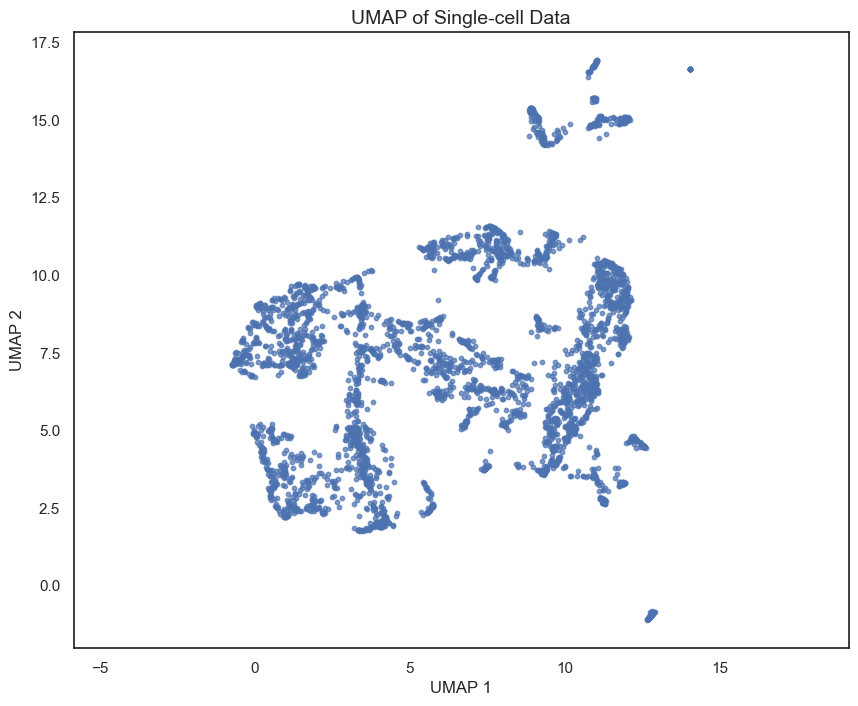

In [10]:
# Step 2: Preprocess the data
preprocessed_data = preprocess_scrna_data(adata.layers["counts"])
# Step 3: Compute UMAP
embedding = compute_umap(preprocessed_data)
# Step 4: Visualize the embedding
plot_umap(embedding, title="UMAP of Single-cell Data")

In [4]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

Exception ignored in: <class 'ValueError'>
Traceback (most recent call last):
  File "mtrand.pyx", line 779, in numpy.random.mtrand.RandomState.randint
  File "_bounded_integers.pyx", line 1423, in numpy.random._bounded_integers._rand_int32
ValueError: high is out of bounds for int32
Exception ignored in: <class 'ValueError'>
Traceback (most recent call last):
  File "mtrand.pyx", line 779, in numpy.random.mtrand.RandomState.randint
  File "_bounded_integers.pyx", line 1423, in numpy.random._bounded_integers._rand_int32
ValueError: high is out of bounds for int32
Exception ignored in: <class 'ValueError'>
Traceback (most recent call last):
  File "mtrand.pyx", line 779, in numpy.random.mtrand.RandomState.randint
  File "_bounded_integers.pyx", line 1423, in numpy.random._bounded_integers._rand_int32
ValueError: high is out of bounds for int32
Exception ignored in: <class 'ValueError'>
Traceback (most recent call last):
  File "mtrand.pyx", line 779, in numpy.random.mtrand.RandomState.r

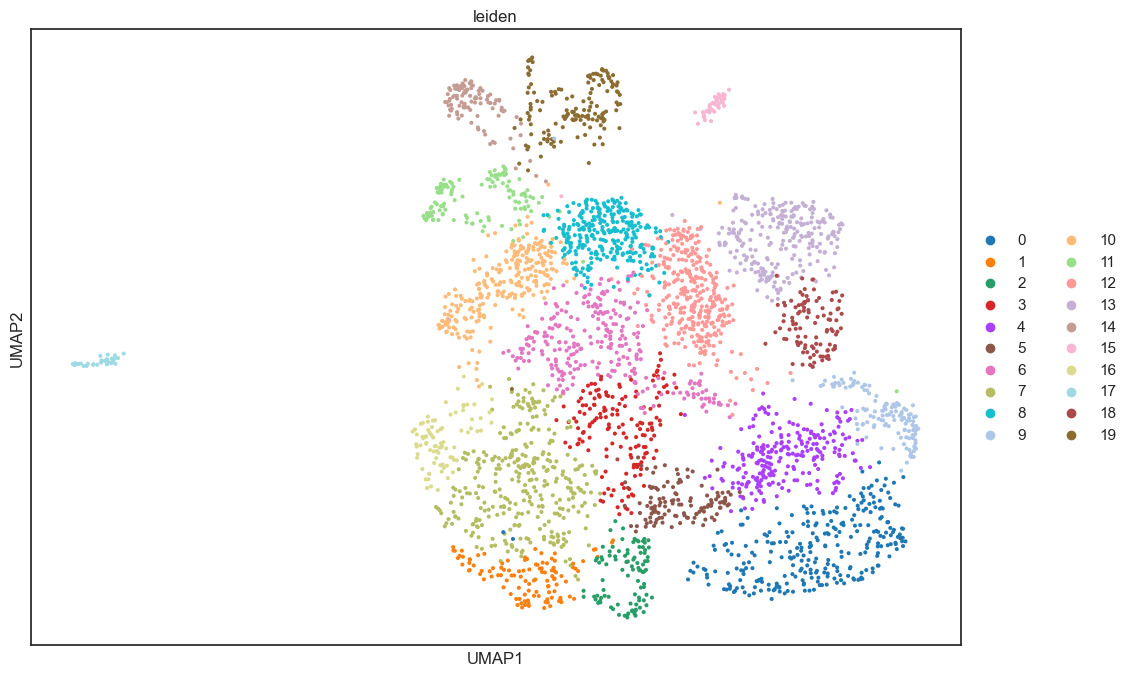

In [5]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
# Step 11: Plot Scanpy's UMAP with Leiden clustering (or any other labels)
sc.pl.umap(adata, color=["leiden"])
